In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#### Loading the dataset

In [73]:
data = pd.read_csv('hotel_bookings.csv')
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

#### EDA & preprocessing

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

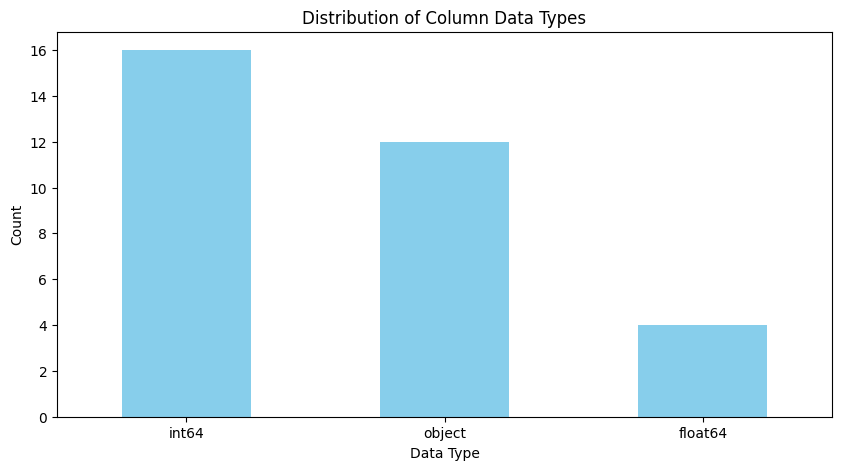

In [75]:
plt.figure(figsize=(10, 5))
data.dtypes.value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Column Data Types")
plt.xlabel("Data Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

In [76]:
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values[missing_values > 0]) 

Missing Values:
children         4
country        488
agent        16340
company     112593
dtype: int64


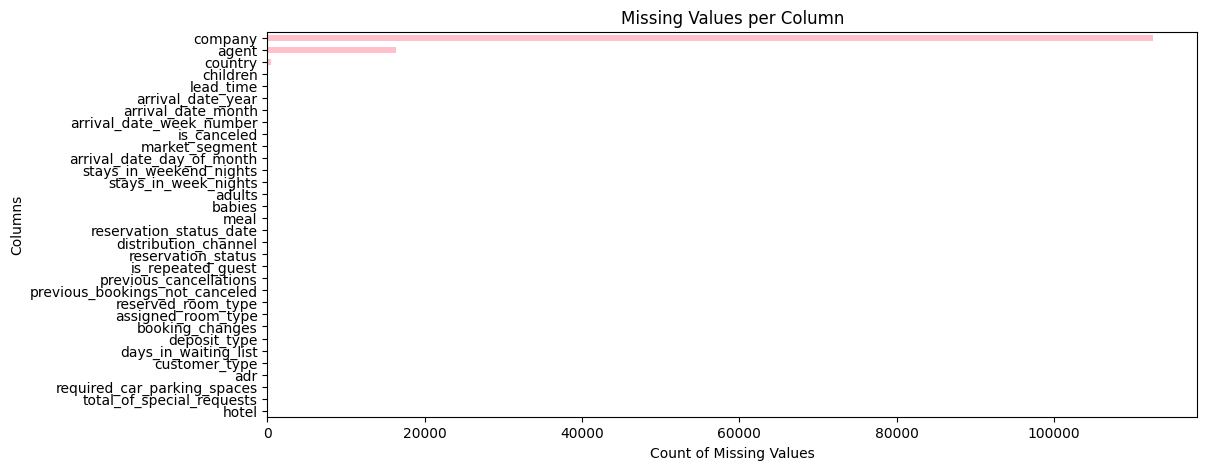

In [77]:
plt.figure(figsize=(12, 5))
missing_values.sort_values().plot(kind='barh', color='pink')
plt.title("Missing Values per Column")
plt.xlabel("Count of Missing Values")
plt.ylabel("Columns")
plt.show()

In [78]:
# Filling the missing values in "children" with 0

data['children']=data['children'].fillna(0)
data['children'] = data['children'].astype('int')

In [79]:
# Dropping company and agent since they have a lot of missing values
data.drop(columns=['agent', 'company', 'country'], inplace=True)

In [80]:
# Check missing values count again
data.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status          

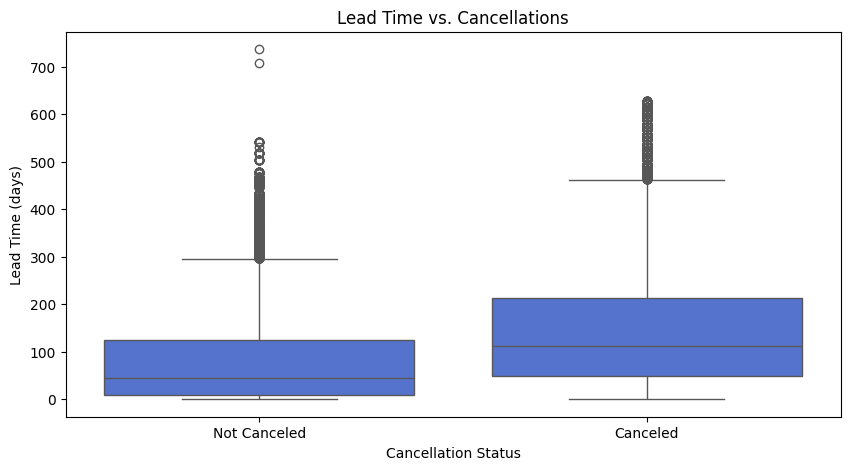

In [25]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='is_canceled', y='lead_time', color='royalblue')
plt.title("Lead Time vs. Cancellations")
plt.xlabel("Cancellation Status")
plt.ylabel("Lead Time (days)")
plt.xticks([0, 1], ['Not Canceled', 'Canceled'])
plt.show()

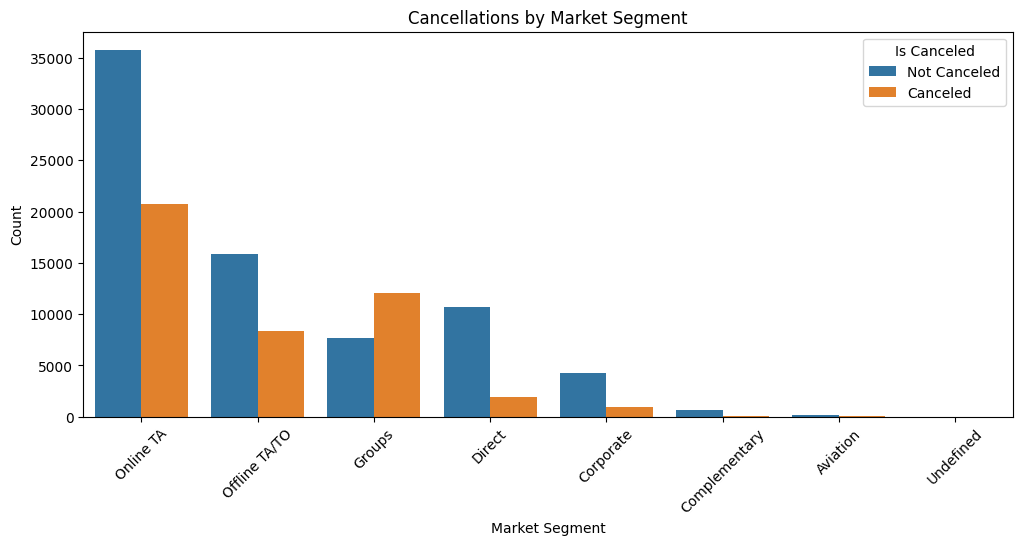

In [28]:
plt.figure(figsize=(12, 5))
sns.countplot(data=data, x='market_segment', hue='is_canceled', order=data['market_segment'].value_counts().index)
plt.title("Cancellations by Market Segment")
plt.xticks(rotation=45)
plt.xlabel("Market Segment")
plt.ylabel("Count")
plt.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'])
plt.show()

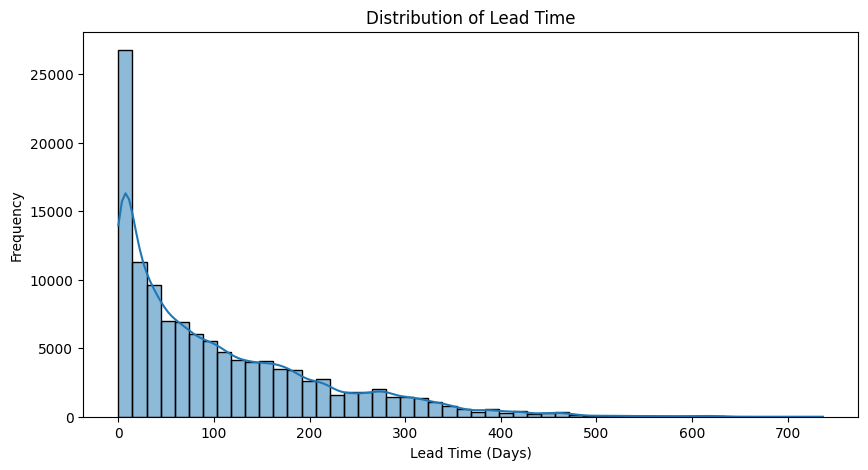

In [38]:
plt.figure(figsize=(10, 5))
sns.histplot(data['lead_time'], bins=50, kde=True, multiple='stack')
plt.title("Distribution of Lead Time")
plt.xlabel("Lead Time (Days)")
plt.ylabel("Frequency")
plt.show()

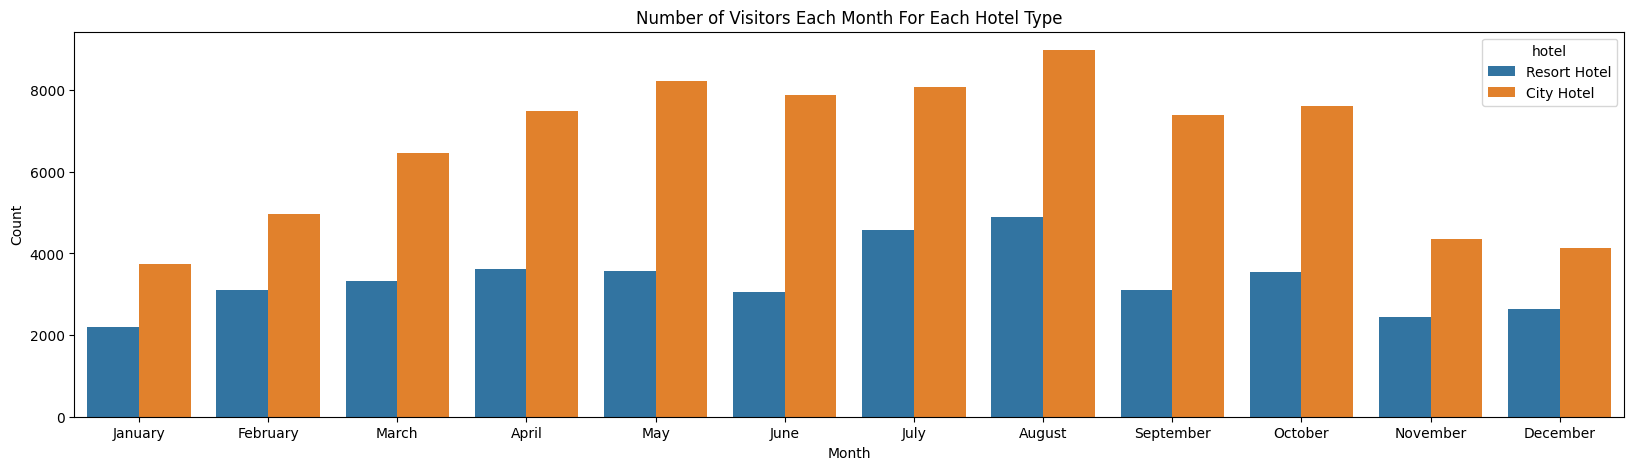

In [47]:
plt.figure(figsize=(20,5))
cols = ['hotel','arrival_date_month']
sns.countplot(data = data[cols],x= "arrival_date_month",hue="hotel",order=["January","February","March","April","May","June",
                                                                              "July","August","September","October","November","December"])
plt.title('Number of Visitors Each Month For Each Hotel Type')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

In [59]:
data['is_canceled'].value_counts()

is_canceled
0    75166
1    44224
Name: count, dtype: int64

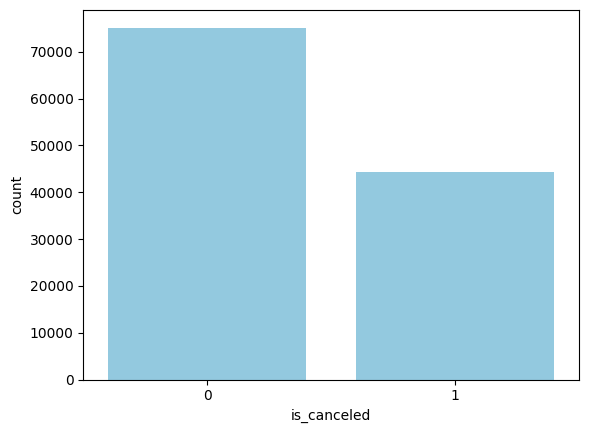

In [61]:
sns.countplot(x=data['is_canceled'], color='skyblue')
plt.show()

In [81]:
data.groupby('arrival_date_month')['is_canceled'].apply(lambda x: (x == 0).mean())

arrival_date_month
April        0.592028
August       0.622469
December     0.650295
February     0.665840
January      0.695227
July         0.625464
June         0.585428
March        0.678477
May          0.603342
November     0.687666
October      0.619534
September    0.608298
Name: is_canceled, dtype: float64

Below is a bar plot showing the aggregated cancelation rates from each month across hotels and years.

C:\Users\Bhagya\AppData\Local\Temp\ipykernel_26820\1810985582.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cancel_rate = df.groupby('arrival_date_month')['is_canceled'].mean().reindex(month_order)


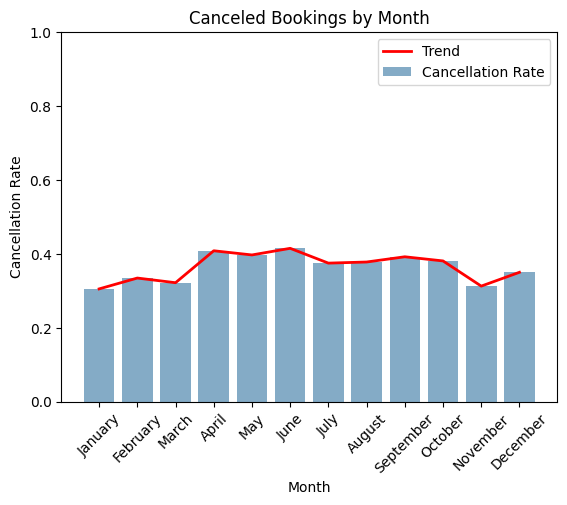

In [88]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
data['arrival_date_month'] = pd.Categorical(data['arrival_date_month'], categories=month_order, ordered=True)
cancel_rate = df.groupby('arrival_date_month')['is_canceled'].mean().reindex(month_order)
sns.barplot(x=cancellation_rate.index, y=cancellation_rate.values, alpha=0.6, label="Cancellation Rate")
sns.lineplot(x=cancellation_rate.index, y=cancellation_rate.values, color='red', linewidth=2, label="Trend")
plt.xlabel("Month")
plt.ylim(0, 1)
plt.ylabel("Cancellation Rate")
plt.title("Canceled Bookings by Month")
plt.xticks(rotation=45) 
plt.legend()
plt.show()

#### Multicollinearity check

In [45]:
covariates = copy.select_dtypes(include=[np.number]).drop(columns=['is_canceled'])
vif_data = pd.DataFrame()
vif_data["Feature"] = covariates.columns
#print(vif_data.isnull().sum())
vif_data["VIF"] = [variance_inflation_factor(covariates.values, i) for i in range(len(covariates.columns))]
vif_data
#print(vif_data)


Feature    0
dtype: int64


,Feature,VIF
0,lead_time,2.226524
1,arrival_date_year,21.351778
2,arrival_date_week_number,5.137844
3,arrival_date_day_of_month,4.269930
4,stays_in_weekend_nights,2.506617
5,stays_in_week_nights,3.745507
6,adults,12.579161
7,children,1.203921
8,babies,1.024092
9,is_repeated_guest,1.304210


In [46]:
#Based on VIFs above, it makes sense to remove adr, adults, arrival_date_year, arrival_date_week_number to avoid multicollinearity

copy.drop(columns=['arrival_date_year', 'arrival_date_week_number', 'adults', 'adr'], inplace=True)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'children', 'babies', 'meal', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status',
       'reservation_status_date'],
      dtype='object')

#### Baseline model (logistic regression)

In [47]:
copy.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'children', 'babies', 'meal', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status',
       'reservation_status_date'],
      dtype='object')

In [51]:
copy.dtypes

hotel                             object
is_canceled                        int64
lead_time                          int64
arrival_date_month                object
arrival_date_day_of_month          int64
stays_in_weekend_nights            int64
stays_in_week_nights               int64
children                           int32
babies                             int64
meal                              object
market_segment                    object
distribution_channel              object
is_repeated_guest                  int64
previous_cancellations             int64
previous_bookings_not_canceled     int64
reserved_room_type                object
assigned_room_type                object
booking_changes                    int64
deposit_type                      object
days_in_waiting_list               int64
customer_type                     object
required_car_parking_spaces        int64
total_of_special_requests          int64
reservation_status                object
reservation_stat

In [75]:
categorical_cols = copy.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.difference(['is_canceled', 'reservation_status', 'reservation_status_date'])
df_encoded = pd.get_dummies(copy, columns=categorical_cols, drop_first=True)
int_cols = copy.select_dtypes(include=['int64', 'int32'])
df_final = pd.concat([int_cols, df_encoded], axis=1)

X = df_final.drop(columns=['is_canceled', 'reservation_status', 'reservation_status_date'])
y = copy['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86     15033
           1       0.83      0.61      0.70      8845

    accuracy                           0.81     23878
   macro avg       0.82      0.77      0.78     23878
weighted avg       0.81      0.81      0.80     23878



This yields an accuracy of 81%. 